In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hrana\.cache\kagglehub\datasets\drgfreeman\rockpaperscissors\versions\2


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
def set_seed(seed:int=42):
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [4]:
# add dataset path
data_dir = path  # The class folders are directly in path
print("Contents of data_dir:", os.listdir(data_dir))

class_names = ['paper', 'rock', 'scissors']
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

for cls in class_names:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        print(f"Number of images in class '{cls}':", len(os.listdir(class_path)))
    else:
        print(f"Warning: {class_path} is not a directory")

Contents of data_dir: ['paper', 'README_rpc-cv-images.txt', 'rock', 'rps-cv-images', 'scissors']
Class names: ['paper', 'rock', 'scissors']
Number of classes: 3
Number of images in class 'paper': 712
Number of images in class 'rock': 726
Number of images in class 'scissors': 750


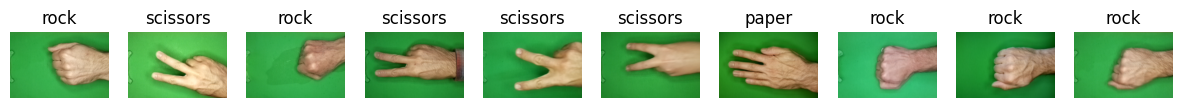

In [5]:
# Data visualization
import random
from PIL import Image

def show_random_images(data_dir, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        cls = random.choice(class_names)
        class_path = os.path.join(data_dir, cls)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.show()

show_random_images(data_dir, class_names, num_images=10)

In [6]:
# Count pixel values and intensities
def analyze_pixel_values(data_dir, class_names):
    pixel_values = []
    pixel_intensities = []
    
    for cls in class_names:
        class_path = os.path.join(data_dir, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_array = np.array(img)
            pixel_values.extend(img_array.flatten())
            pixel_intensities.append(np.mean(img_array))
    
    pixel_values = np.array(pixel_values)
    pixel_intensities = np.array(pixel_intensities)
    
    print("Pixel Values Analysis:")
    print(f"Min: {pixel_values.min()}, Max: {pixel_values.max()}")
    print(f"Mean: {pixel_values.mean()}, Std: {pixel_values.std()}")
    
    print("\nPixel Intensities Analysis:")
    print(f"Min: {pixel_intensities.min()}, Max: {pixel_intensities.max()}")
    print(f"Mean: {pixel_intensities.mean()}, Std: {pixel_intensities.std()}")

analyze_pixel_values(data_dir, class_names)

Pixel Values Analysis:
Min: 0, Max: 253
Mean: 114.36178860450944, Std: 30.91488603713056

Pixel Intensities Analysis:
Min: 70.19153333333334, Max: 160.41836666666666
Mean: 114.36178860450943, Std: 10.143539821171627


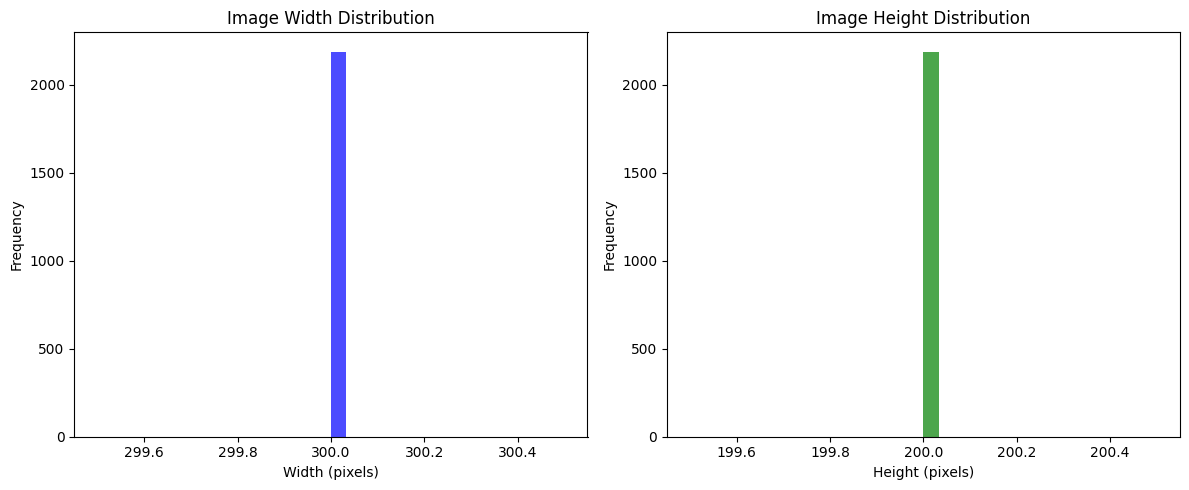

In [7]:
# plot image dimension distribution
def plot_image_dimension_distribution(data_dir, class_names):
    widths = []
    heights = []
    
    for cls in class_names:
        class_path = os.path.join(data_dir, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='blue', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='green', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_image_dimension_distribution(data_dir, class_names)

In [8]:
# Data augmentation and normalization for training
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [9]:
from torchvision.datasets import ImageFolder

class TransformSubset:
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.subset)

def count_images_per_class(dataset, classes):
    class_counts = {cls: 0 for cls in classes}
    for _, label in dataset:
        class_counts[classes[label]] += 1
    return class_counts

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, allowed_classes=None):
        super().__init__(root, transform=transform)
        if allowed_classes is not None:
            samples = []
            class_to_idx = {}
            for i, class_name in enumerate(allowed_classes):
                if class_name in self.class_to_idx:
                    old_idx = self.class_to_idx[class_name]
                    class_to_idx[class_name] = i
                    samples.extend([
                        (path, i) for path, label in self.samples 
                        if label == old_idx
                    ])
            self.samples = samples
            self.targets = [s[1] for s in samples]
            self.classes = allowed_classes
            self.class_to_idx = class_to_idx

full_dataset = CustomImageFolder(data_dir, allowed_classes=['paper', 'rock', 'scissors'])
print("Classes found:", full_dataset.classes)
print("Total images:", len(full_dataset))

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_indices, val_indices, test_indices = random_split(
    range(len(full_dataset)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = TransformSubset(
    Subset(full_dataset, train_indices.indices),
    transform=data_transforms['train']
)
val_dataset = TransformSubset(
    Subset(full_dataset, val_indices.indices),
    transform=data_transforms['val']
)
test_dataset = TransformSubset(
    Subset(full_dataset, test_indices.indices),
    transform=data_transforms['test']
)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Testing dataset size:", len(test_dataset))

Classes found: ['paper', 'rock', 'scissors']
Total images: 2188
Training dataset size: 1750
Validation dataset size: 218
Testing dataset size: 220


In [10]:
print("Class to index mapping:", full_dataset.class_to_idx)
sample_image, sample_label = train_dataset[0]
print("Sample shape:", sample_image.shape)
print("Sample label:", full_dataset.classes[sample_label])

Class to index mapping: {'paper': 0, 'rock': 1, 'scissors': 2}
Sample shape: torch.Size([3, 224, 224])
Sample label: paper


In [11]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

Train batches: 55
Val batches: 7
Test batches: 7


In [12]:
import torchvision.models as models

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet18.parameters():
    param.requires_grad = False

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print("Model setup complete!")

Model setup complete!


In [13]:
# Training and evaluation function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict().copy()
    best_acc = 0.0
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
            
            # Step the scheduler
            if phase == 'val':
                scheduler.step(epoch_loss)
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

In [14]:
# Train the model
num_epochs = 25
print("Starting training...")
trained_model, history = train_model(
    resnet18, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)

print("Training complete!")
torch.save(trained_model.state_dict(), 'resnet18_rps_best_model.pth')
print("Model saved successfully!")

Starting training...
Epoch 1/25
----------
train Loss: 0.6841 Acc: 0.7566
val Loss: 0.2601 Acc: 0.9771

Epoch 2/25
----------
train Loss: 0.3720 Acc: 0.8971
val Loss: 0.1473 Acc: 0.9817

Epoch 3/25
----------
train Loss: 0.3438 Acc: 0.8800
val Loss: 0.1066 Acc: 0.9862

Epoch 4/25
----------
train Loss: 0.3083 Acc: 0.8954
val Loss: 0.0938 Acc: 0.9954

Epoch 5/25
----------
train Loss: 0.2970 Acc: 0.8943
val Loss: 0.0774 Acc: 0.9862

Epoch 6/25
----------
train Loss: 0.2653 Acc: 0.9120
val Loss: 0.0708 Acc: 0.9862

Epoch 7/25
----------
train Loss: 0.2684 Acc: 0.9074
val Loss: 0.0707 Acc: 0.9817

Epoch 8/25
----------
train Loss: 0.2462 Acc: 0.9086
val Loss: 0.0686 Acc: 0.9862

Epoch 9/25
----------
train Loss: 0.2508 Acc: 0.9034
val Loss: 0.0656 Acc: 0.9862

Epoch 10/25
----------
train Loss: 0.2639 Acc: 0.9080
val Loss: 0.0620 Acc: 0.9862

Epoch 11/25
----------
train Loss: 0.2484 Acc: 0.9120
val Loss: 0.0645 Acc: 0.9771

Epoch 12/25
----------
train Loss: 0.2356 Acc: 0.9063
val Loss: 

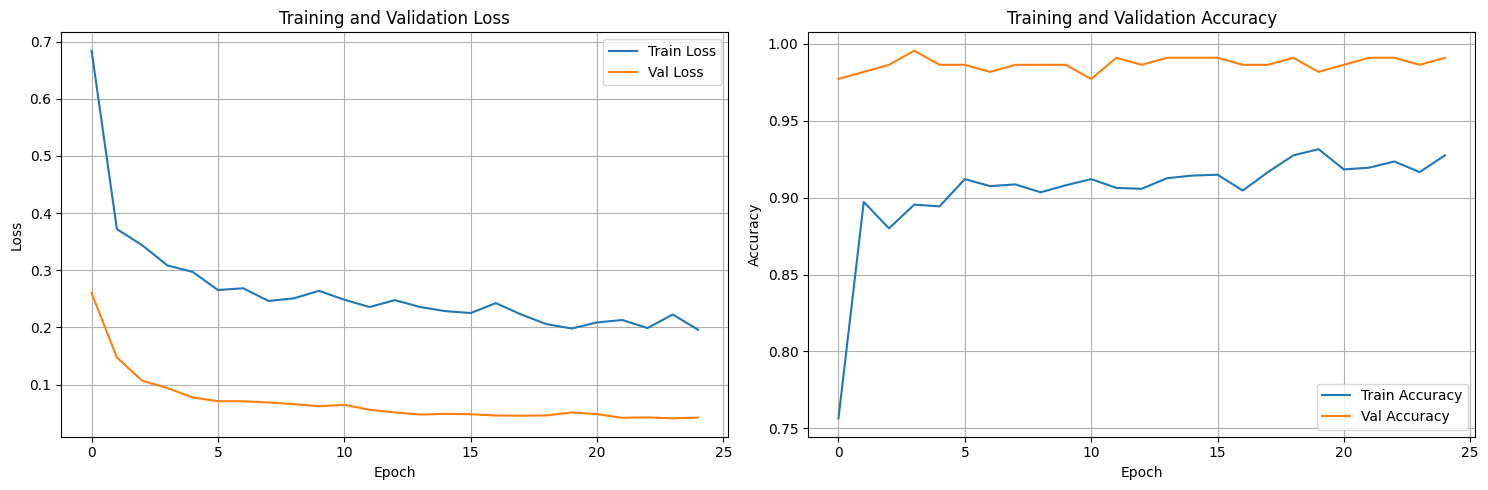

In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

       paper       1.00      0.98      0.99        84
        rock       1.00      1.00      1.00        64
    scissors       0.97      1.00      0.99        72

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220



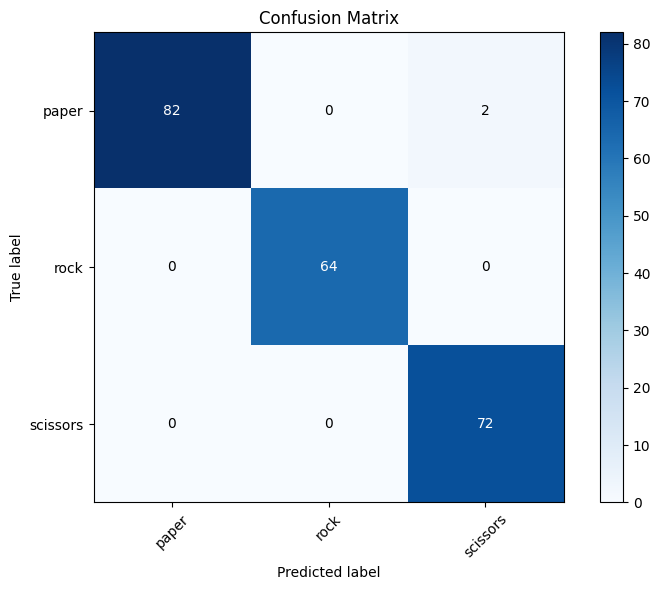

In [16]:
# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions
predictions, true_labels = evaluate_model(trained_model, test_loader)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=full_dataset.classes))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(full_dataset.classes))
plt.xticks(tick_marks, full_dataset.classes, rotation=45)
plt.yticks(tick_marks, full_dataset.classes)

# Annotate each cell with the numeric value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()